# import libraries

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score
from custom_CNN import CustomCNN
import psutil

torch.Size([1, 10])


# training and testing functions

In [30]:
import time

def train_model(model,device,train_loader, learning_rate, num_epochs):
    # Print training details
    batch_size = train_loader.batch_size
    print(f"Batch Size: {batch_size}")
    print(f"Number of Epochs: {num_epochs}")
    print(f"Learning Rate (starting): {learning_rate}")

    # Modify the model's final layer
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward propagation
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print loss per epoch
        print(f"Epoch: [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    # Calculate latency for a single sample
    model.eval() 
    with torch.no_grad():
        start_time = time.time()
        for images, _ in train_loader:
            images = images.to(device)
            # Simulate processing a single sample
            for i in range(images.size(0)):
                _ = model(images[i].unsqueeze(0))
            break  # Measure for one batch
        end_time = time.time()
    
    checkpoint_path = f'model-{batch_size}-{epoch}-{str(learning_rate)}.pth'

    # Create a dictionary containing the model and optimizer state_dict
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }

    # Save the checkpoint
    torch.save(checkpoint, checkpoint_path)
    # Latency per sample
    latency_per_sample = (end_time - start_time) / images.size(0)
    print(f"Latency per sample: {latency_per_sample * 1000:.2f} ms")
    return latency_per_sample * 1000


def measure_latency_cpu_usage(model, test_inputs):
    process = psutil.Process()
    cpu_start = process.cpu_percent()
    start = time.time()
    predictions = model(test_inputs)
    end = time.time()
    cpu_end = process.cpu_percent()
    latency = end - start
    cpu_usage = cpu_end - cpu_start
    return latency, cpu_usage

def test_model(test_loader, model, device):
    model.eval()
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    
    total_latency = 0
    total_cpu_usage = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Measure latency and CPU usage
            latency, cpu_usage = measure_latency_cpu_usage(model, images)
            total_latency += latency
            total_cpu_usage += cpu_usage
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predicted_labels.extend(predicted.to('cpu').tolist())
            true_labels.extend(labels.to('cpu').tolist())
    
    # Calculate averages
    avg_latency_per_batch = total_latency / len(test_loader)
    avg_cpu_usage = total_cpu_usage / len(test_loader)
    accuracy = 100 * correct / total
    
    print(f"Average Latency per Batch: {avg_latency_per_batch * 1000:.2f} ms")
    print(f"Average CPU Usage per Batch: {avg_cpu_usage:.2f}%")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return accuracy,predicted_labels, true_labels


Total Inference Time: 0.10 seconds
Latency per Sample: 0.01 ms
Average Latency per Batch: 0.16 ms
Test Accuracy: 98.62%


# setting the device for execution - gpu or cpu

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters

In [5]:
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate =0.0001

# pre processing functions

In [6]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28,28)),    
  transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28,28)),    
  transforms.Normalize((0.5,), (0.5,))
])

## downloading public dataset - CIFAR10

In [7]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transforms, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transforms, download=True)

# loading ResNet18 model

In [8]:
model = CustomCNN(10)

In [9]:
batch_sizes = [16,32,64,128]
num_epochs = [10,50,100]
learning_rate = [0.001,0.0001,0.00001]
data = []
for batch_size in batch_sizes:
    for epochs in num_epochs:
        for lr in learning_rate:
            
            train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
            latency = train_model(model,device,train_loader,lr,epochs)
            accuracy,predictedLabels,trueLabels = test_model(test_loader,model,device=device)
            
            cm = confusion_matrix(trueLabels, predictedLabels)
            fig, ax = plt.subplots(figsize=(8,8))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=range(10))
            disp.plot(ax=ax, cmap='Blues', colorbar=True)
            plt.title("Confusion Matrix for 10 Classes")
            plt.show()
            
            f1_score_data = f1_score(trueLabels, predictedLabels,average="macro")
            data.append({
                "batch_size":batch_size,
                "learning_rate":lr,
                "epochs":epochs,
                "accuracy":accuracy,
                "f1_score":f1_score_data,
                "latency":latency
            })

In [10]:
data

# performing image augmentations

In [11]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),   # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
    transforms.RandomRotation(15),         # Random rotation within 15 degrees
    transforms.ToTensor(),                 # Convert to tensor
        transforms.Resize((28,28)),    
  transforms.Normalize((0.5,), (0.5,))
])

# Test data transformations (no augmentation)
test_transforms = transforms.Compose([
        transforms.Resize((28,28)),    
    transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transforms, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transforms, download=True)

Batch Size: 16
Number of Epochs: 10
Learning Rate (starting): 0.001
Epoch: [1/10], Loss: 0.3622
Epoch: [2/10], Loss: 0.1652
Epoch: [3/10], Loss: 0.1261
Epoch: [4/10], Loss: 0.1083
Epoch: [5/10], Loss: 0.0976
Epoch: [6/10], Loss: 0.0948
Epoch: [7/10], Loss: 0.0860
Epoch: [8/10], Loss: 0.0814
Epoch: [9/10], Loss: 0.0812
Epoch: [10/10], Loss: 0.0755
Latency per sample: 2.65 ms
Average Latency per Batch: 0.44 ms
Average CPU Usage per Batch: 85.11%
Test Accuracy: 98.62%


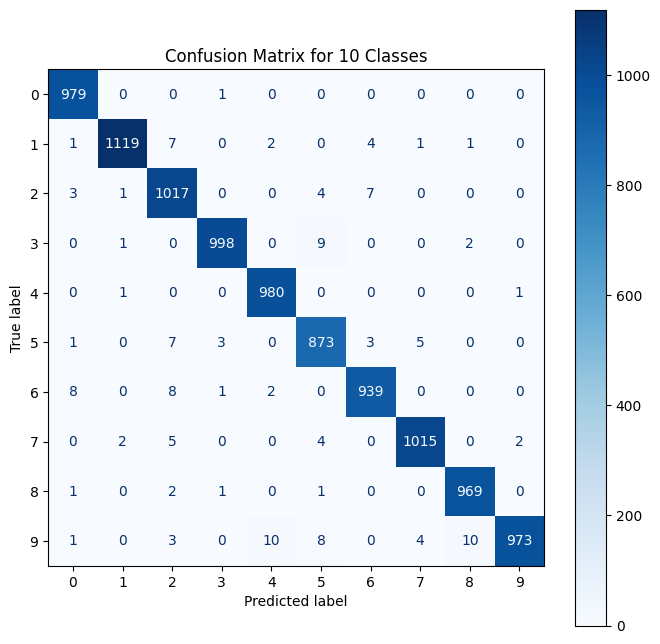

In [12]:
batch_sizes = [16,32,64,128]
num_epochs = [10,50,100]
learning_rate = [0.001,0.0001,0.00001]
aug_data = []
for batch_size in batch_sizes:
    for epochs in num_epochs:
        for lr in learning_rate:
            
            train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
            latency = train_model(model,device,train_loader,lr,epochs)
            accuracy,predictedLabels,trueLabels = test_model(test_loader,model,device=device)
            
            cm = confusion_matrix(trueLabels, predictedLabels)
            fig, ax = plt.subplots(figsize=(8,8))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=range(10))
            disp.plot(ax=ax, cmap='Blues', colorbar=True)
            plt.title("Confusion Matrix for 10 Classes")
            plt.show()
            
            f1_score_data = f1_score(trueLabels, predictedLabels,average="macro")
            aug_data.append({
                "batch_size":batch_size,
                "learning_rate":lr,
                "epochs":epochs,
                "accuracy":accuracy,
                "f1_score":f1_score_data
            })
            break
        break
    break

# adding tensor rt


In [13]:
import torch_tensorrt

/home/rohithk/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
import os
os.environ["TORCH_LOGS"] = "+dynamo"
os.environ["TORCHDYNAMO_VERBOSE"] = "1"


In [26]:
import torch
import torch_tensorrt

trt_module = torch_tensorrt.compile(
    model,
    inputs=[torch_tensorrt.Input((16, 1, 28, 28))],  
    enabled_precisions={torch_tensorrt.dtype.half}   
)

example_input = torch.randn(16, 1, 28, 28).cuda()  
scripted_trt_module = torch.jit.trace(trt_module, example_input)

torch.jit.save(scripted_trt_module, "trt_torchscript_module.ts")

In [ ]:
import time
import torch
import torch_tensorrt
from torch.utils.data import DataLoader

loaded_module = torch.jit.load("trt_torchscript_module.ts")
loaded_module.eval() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_module = loaded_module.to(device)

total_time = 0
num_samples = 0
num_batches = 0

results = []
with torch.no_grad():  
    for inputs, labels in test_loader: 
        batch_size = inputs.size(0)
        inputs = inputs.to(device) 

        start_time = time.time()
        outputs = loaded_module(inputs) 
        end_time = time.time()

        batch_time = end_time - start_time
        total_time += batch_time
        num_samples += batch_size
        num_batches += 1

        results.append((outputs, labels)) 

latency_per_sample = (total_time / num_samples) * 1000  
average_latency_per_batch = (total_time / num_batches) * 1000  

print(f"Total Inference Time: {total_time:.2f} seconds")
print(f"Latency per Sample: {latency_per_sample:.2f} ms")
print(f"Average Latency per Batch: {average_latency_per_batch:.2f} ms")

correct = 0
total = 0
for outputs, labels in results:
    predictions = torch.argmax(outputs, dim=1)  
    correct += (predictions == labels.to(device)).sum().item()
    total += labels.size(0)

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Total inference time: 1.35 seconds
Test Accuracy: 98.62%
